In [1]:
from sklearn.datasets import make_moons, make_classification, make_circles, make_blobs
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
from itertools import cycle, islice
import matplotlib
import warnings
from matplotlib.ticker import MaxNLocator
warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'font.size': 20})

In [2]:
###toy 2
np.random.seed(4) 
X,y = make_blobs(n_samples=400, centers=2, cluster_std=0.7)
X[:,0] -= 9.3
X[:,1] -= 2.5

np.random.seed(1)
pos_ids = np.where(y == 0)[0]
neg_ids = np.where(y == 1)[0]
ids1 = np.random.randint(0,len(pos_ids),5)
ids2 = np.random.randint(0,len(neg_ids),5)
p1 = pos_ids[ids1]
p2 = neg_ids[ids2]

## generate labeled and unlabeled data
l_ids = np.concatenate((p1 , p2))
u_ids = np.array(list(set(np.arange(X.shape[0])) - set(l_ids)))
l_data1, l_data2 = X[l_ids,0].reshape(-1,1), X[l_ids,1].reshape(-1,1)
u_data1, u_data2 = X[u_ids,0].reshape(-1,1), X[u_ids,1].reshape(-1,1)
labels = y[l_ids]


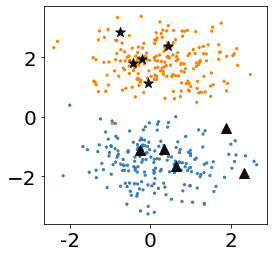

In [3]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y) + 3))))
fig = plt.figure(figsize=(4,4))
x = [-1.5,0,1.5]
my_xticks=[-2,0,2]
plt.xticks(x, my_xticks)
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[y], s=5)
plt.scatter(X[p1,0], X[p1,1], marker='^', c='#0F0F0F', s=100)
plt.scatter(X[p2,0], X[p2,1], marker='*', c='#0F0F0F', s=100)
plt.show()



In [4]:
import copy
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC,SVC, NuSVC
from copy import deepcopy

def sel_ids_y(score, add_num = 10):
    ids_sort = np.argsort(score)
    add_id = np.zeros(score.shape[0])
    add_id[ids_sort[:add_num]] = -1
    add_id[ids_sort[-add_num:]] = 1
    return add_id
    
def update_train_untrain(sel_ids, train_data, train_labels, untrain_data, weights=None):
#     sel_ids = np.array(sel_ids, dtype='bool')
    add_ids = np.where(np.array(sel_ids) != 0)[0]
    untrain_ids = np.where(np.array(sel_ids) == 0)[0]
    add_datas = [d[add_ids] for d in untrain_data]
    new_train_data = [np.concatenate([d1, d2]) for d1,d2 in zip(train_data, add_datas)]
    add_y = [1 if sel_ids[idx] > 0 else 0 for idx in add_ids]
    new_train_y = np.concatenate([train_labels, add_y])
    new_untrain_data = [d[untrain_ids] for d in untrain_data]
    return new_train_data, new_train_y, new_untrain_data


def cotrain(labeled_data, labels, unlabeled_data, iter_step=1):
    lbls = copy.deepcopy(labels)
    for step in range(iter_step):
        scores = []
        add_ids = []
        add_ys = []
        clfs = []
        for view in range(2):
            clfs.append(LinearSVC())
            clfs[view].fit(labeled_data[view], lbls)
            scores.append(clfs[view].decision_function(unlabeled_data[view]))
            add_id = sel_ids_y(scores[view], 6)
            add_ids.append(add_id)
        add_id = sum(add_ids)
        labeled_data, lbls, unlabeled_data = update_train_untrain(add_id, labeled_data, lbls, unlabeled_data)
        if len(unlabeled_data[view]) <= 0:
            break
    return clfs
        


def update_train(sel_ids, train_data, train_labels, untrain_data, pred_y):
    add_ids = np.where(np.array(sel_ids) != 0)[0]
    add_data = [d[add_ids] for d in untrain_data]
    new_train_data = [np.concatenate([d1, d2]) for d1,d2 in zip(train_data, add_data)]
    add_y = pred_y[add_ids]
    new_train_y = np.concatenate([train_labels, pred_y[add_ids]])
    return new_train_data, new_train_y


def spaco(l_data, lbls, u_data, iter_step = 1, gamma = 0.5):
    
    # initiate classifier
    clfs = []
    scores = []
    add_ids = []
    add_num = 6
    clfss = []
    for view in range(2):
        clfs.append(LinearSVC())
        clfs[view].fit(l_data[view], lbls)
        scores.append(clfs[view].decision_function(u_data[view]))
        add_ids.append(sel_ids_y(scores[view], add_num))
        py = [0  if s < 0 else 1 for s in scores[view]]
    score = sum(scores)
    pred_y = np.array([0  if s < 0 else 1 for s in score])
    for step in range(iter_step):
        for view in range(2):
            if add_num * 2 > u_data[0].shape[0]: break
            #update v
            ov = np.where(add_ids[1-view] != 0)[0]
            scores[view][ov] += add_ids[1-view][ov] * gamma
            add_ids[view] = sel_ids_y(scores[view], add_num)
            
            
            #update w
            nl_data, nlbls = update_train(add_ids[view], l_data, lbls, u_data, pred_y)
            clfs[view].fit(nl_data[view], nlbls)
            
            # update y, v
            scores[view] = clfs[view].decision_function(u_data[view])
            add_num += 6
            scores[view][ov] += add_ids[1-view][ov] * gamma
            add_ids[view] = sel_ids_y(scores[view], add_num)
            
            
            score = sum(scores)
            
            pred_y = np.array([0  if s < 0 else 1 for s in score])
            py = [0  if s < 0 else 1 for s in scores[view]]
    return clfs

cotrain: 0.745
spaco experiment(gamma=3): 0.77250
spaco experiment(gamma=0.3): 0.99500


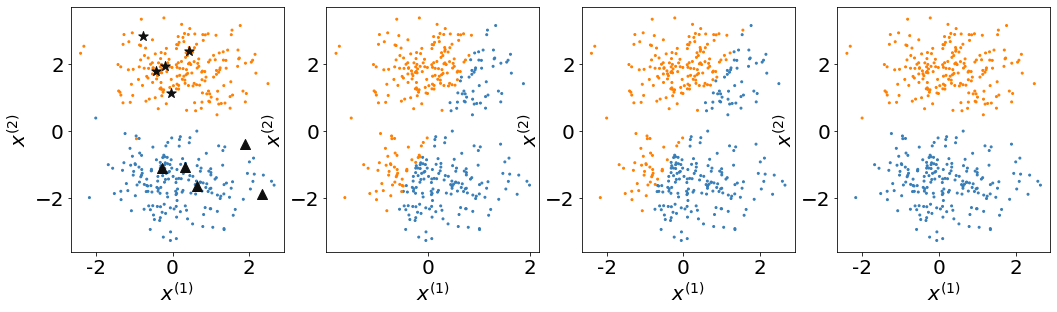

In [5]:
x = [-1.5,0,1.5]
my_xticks=[-2,0,2]

### parameters
steps = 16
gamma = 3

### original fig
fig = plt.figure(figsize=(16,4))
plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=0.9)

ax = fig.add_subplot(141)
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[y], s=4)
plt.scatter(X[p1,0], X[p1,1], marker='^', c='#0F0F0F', s=100)
plt.scatter(X[p2,0], X[p2,1], marker='*', c='#0F0F0F', s=100)
ax.set_xlabel('$x^{(1)}$')
ax.set_ylabel('$x^{(2)}$')
plt.xticks(x, my_xticks)
     
    
#### cotrain experiment
clfs = cotrain([l_data1, l_data2], labels, [u_data1, u_data2], iter_step=steps)
score1 = clfs[0].decision_function(X[:,0].reshape(-1,1))
score2 = clfs[1].decision_function(X[:,1].reshape(-1,1))
score = score1 + score2
pred_y = np.array([0  if s < 0 else 1 for s in score])
print('cotrain:', np.mean(pred_y == y))


ax = fig.add_subplot(142)      
ax.set_xlabel('$x^{(1)}$')
ax.set_ylabel('$x^{(2)}$')
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[pred_y], s=4)

#### spaco experiment1 gamma=3
clfs = spaco([l_data1, l_data2], labels, [u_data1, u_data2], iter_step=steps, gamma=3)
score1 = clfs[0].decision_function(X[:,0].reshape(-1,1))
score2 = clfs[1].decision_function(X[:,1].reshape(-1,1))
score = score1 + score2
pred_y = np.array([0  if s < 0 else 1 for s in score])
print('spaco experiment(gamma=3): %0.5f' % np.mean(pred_y == y))
ax = fig.add_subplot(143)    
ax.set_xlabel('$x^{(1)}$')
ax.set_ylabel('$x^{(2)}$')
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[pred_y], s=4)
plt.xticks(x, my_xticks)

#### spaco experiment2 gamma=0.3
clfs = spaco([l_data1, l_data2], labels, [u_data1, u_data2], iter_step=steps, gamma=0.3)
score1 = clfs[0].decision_function(X[:,0].reshape(-1,1))
score2 = clfs[1].decision_function(X[:,1].reshape(-1,1))
score = score1 + score2
pred_y = np.array([0  if s < 0 else 1 for s in score])
print('spaco experiment(gamma=0.3): %0.5f' % np.mean(pred_y == y))
ax = fig.add_subplot(144)    
ax.set_xlabel('$x^{(1)}$')
ax.set_ylabel('$x^{(2)}$')
plt.scatter(X[:,0], X[:,1], marker='o', c=colors[pred_y], s=4)
plt.xticks(x, my_xticks)

plt.show()

In [12]:
X

array([[-0.29426127,  1.66028845],
       [-0.12057295,  2.47568436],
       [-0.24588129,  1.75711014],
       [ 0.9896716 ,  2.37245967],
       [ 0.99404336,  2.12648245],
       [-1.06558334,  1.99350086],
       [-0.78467243, -0.74611577],
       [ 1.05274978, -1.54663303],
       [ 0.90312562,  0.81262076],
       [ 1.16221236,  3.0214194 ],
       [-0.73331205, -0.96886957],
       [ 0.48101725, -1.02675594],
       [ 0.69468994,  2.91158838],
       [ 0.95237259,  0.83053136],
       [-1.79784917,  2.32880691],
       [ 0.35862278, -1.84548665],
       [ 1.5383815 ,  2.06499826],
       [ 0.47366556, -1.61694587],
       [-0.7691746 , -1.30965701],
       [-0.10455098, -0.77893281],
       [ 0.08053679, -1.85619174],
       [ 0.54693591, -1.52306012],
       [-0.42353823, -1.62279668],
       [ 0.3262375 , -0.34267606],
       [-0.00888282,  1.12836177],
       [-0.24636354,  1.26846166],
       [-0.39272236,  2.73165802],
       [ 1.07725883,  2.42575631],
       [-1.05340952,

In [13]:
l_data1

array([[ 1.74245358],
       [-0.19700382],
       [ 1.41870035],
       [ 0.25101675],
       [ 0.47091522],
       [ 0.32854249],
       [-0.56998318],
       [-0.03809326],
       [-0.15331413],
       [-0.32256242]])

In [14]:
l_data2

array([[-1.88102913],
       [-1.09886711],
       [-0.38432052],
       [-1.06879018],
       [-1.64395303],
       [ 2.39106126],
       [ 2.85709059],
       [ 1.14318965],
       [ 1.93938739],
       [ 1.80390353]])

In [15]:
[l_data1, l_data2]

[array([[ 1.74245358],
        [-0.19700382],
        [ 1.41870035],
        [ 0.25101675],
        [ 0.47091522],
        [ 0.32854249],
        [-0.56998318],
        [-0.03809326],
        [-0.15331413],
        [-0.32256242]]),
 array([[-1.88102913],
        [-1.09886711],
        [-0.38432052],
        [-1.06879018],
        [-1.64395303],
        [ 2.39106126],
        [ 2.85709059],
        [ 1.14318965],
        [ 1.93938739],
        [ 1.80390353]])]

In [16]:
labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [18]:
u_data2

array([[ 1.66028845],
       [ 2.47568436],
       [ 1.75711014],
       [ 2.37245967],
       [ 2.12648245],
       [ 1.99350086],
       [-0.74611577],
       [-1.54663303],
       [ 0.81262076],
       [ 3.0214194 ],
       [-0.96886957],
       [-1.02675594],
       [ 2.91158838],
       [ 0.83053136],
       [ 2.32880691],
       [-1.84548665],
       [ 2.06499826],
       [-1.61694587],
       [-1.30965701],
       [-0.77893281],
       [-1.85619174],
       [-1.52306012],
       [-1.62279668],
       [-0.34267606],
       [ 1.12836177],
       [ 1.26846166],
       [ 2.73165802],
       [ 2.42575631],
       [ 1.20403017],
       [-0.78363086],
       [ 2.13128953],
       [ 1.92326986],
       [-0.91496635],
       [ 1.58941755],
       [ 2.01450818],
       [ 3.38502027],
       [ 2.12899194],
       [ 2.48502511],
       [ 1.36955212],
       [ 2.93895618],
       [-1.01355554],
       [ 1.20086044],
       [ 1.87866604],
       [ 2.18784643],
       [-0.99552614],
       [-1

In [33]:
clss_ids = [np.where(y[1] == c)[0] for c in [0,1]]

In [34]:
clss_ids

[array([], dtype=int64), array([0], dtype=int64)]

In [28]:
np.array([np.random.choice(c_id, 5) for c_id in clss_ids])

ValueError: 'a' cannot be empty unless no samples are taken